# Time-Varying Effect of Financialization on Oil Futures

I use Kalman filters (implemented via filterpy) to estimate time trends in the oil market. My work primarily splits into 2 sections - impulse response of exogenous shocks and systematic risk with financial markets.

### Measurement (update) equations:

For the following let $y$ be the simple returns of oil prices and $x$ be the simple returns of exogenous variables.

Linear impulse response model: $y_t = \Sigma_{p=0}^1 \beta_p S_{t-p} + \epsilon_t$ (where $S$ is a shock variable derived from $x$)
- We use this model to test for response of oil returns to exogenous shocks at horizons 0, 1

Linear systematic risk model: $y_t = \beta_t x_t + \epsilon_t$
- We use this model to test for comovement between oil returns and the returns of an exogenous market

Note that no constant is assumed due to the time-varying nature of the equations (?), and all returns are standardized and seasonally adjusted prior to analysis.

Both these models can be translated into state space form where $\beta$ is the underlying state using $\bf z = H\beta$ where $\bf z$ represents a given vector of observations in place of $y$ and $\bf H$ maps observations to the hidden state. At least one observation is needed in $\bf z$ each $\beta$ in the equation. However, I have difficulty getting filterpy to solve for $p>1$. It's fine seeing as we're modelling short term shocks (OLS confirms most significant variable in 12 months is at months zero and one).

### Prediction equations

Kalman filters work by predicting the position of the time $t$ state at $t-1$ and then using Gaussian distributions to estimate the most probable position of the state given 1) the prediction, and 2) observation $z$ at time $t$. As such they can be thought of in Bayesian terms where the observation $z$ helps to update the prior belief.

Following the work of Faff, Hillier and Hillier (2003), I assume a random walk model for the $\beta$ states. As such, I modify the prediction equation $\bf\bar\beta = F \beta$ such that $\bar\beta = \beta$ by setting $\bf F = J$ (matrix of ones) in filterpy. 

### Obtaining the estimate

The beauty of the Kalman filter is its improvement over g-h filters and discrete Bayesian filters using the continuous (and multi-dimensional) Gaussian distribution such that $\beta \sim N(\beta, \bf P)$ and $\bf{z}$$ \sim N(\bf z, R)$. Similar to how $\beta$ predictions are gotten using $\bf\bar\beta = F \beta$, we can also have $\bf\bar P = FPF^\top + Q$. The estimate $\beta$ then becomes a weighted function of the residual between the prediction and observation, expressed as $\beta = \bar\beta + \bf K(z - H\bar\beta)$ where $\bf K$ is solved using the maximum likelihood estimator $\bf K = \bar PH^\top(H\bar PH^\top + R)$$^{-1}$. The variance of $\beta$ is also updated with each stage in the process using $\bf P = (I - KH)\bar P$.

The three steps are solved by filterpy once initial matrices are set.

In [1]:
from utils.models import *
env()

--------- Dependencies ---------
python: 3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:25:23) [MSC v.1916 64 bit (AMD64)]
numpy: 1.21.0
pandas: 1.2.4
matplotlib: 3.4.2
scipy: 1.7.1
statsmodels: 0.13.0
filterpy: 1.4.5


# Downward Movements

## 1. Does It Work?

Test impulse response on geopoltical risk index constructed by Dario and Iacoviello (2021). WTI values (and all following dollar values) have been converted in Dec 2021 terms.

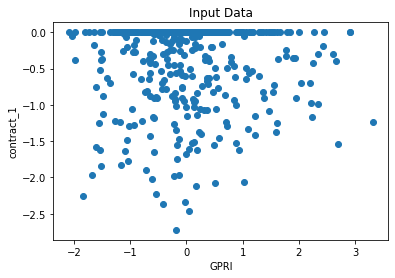

In [2]:
wti = clean_series('contract_1', load('data/WTI.csv').pct_change())
wti.contract_1 = wti.contract_1.apply(lambda x: 0 if x > 0 else x)
gpr_shocks = calc_shock('GPRI', load('data/GPRGlobal.csv'))
kalman_response_model = KF(lags=1)
gpr_response = kalman_response_model.run('contract_1', 'GPRI', wti.join(gpr_shocks).dropna(), show_scatter=True)

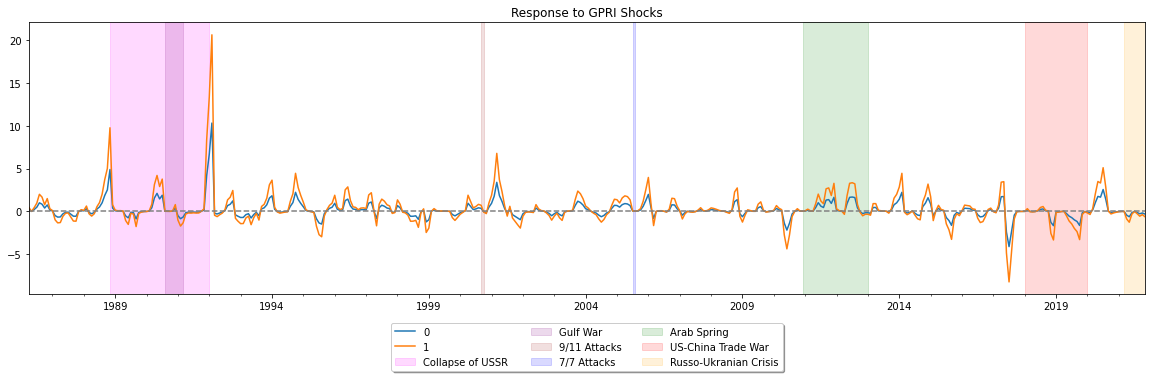

In [3]:
hp_kalman_plot(gpr_response, hp_trend=False, recessions=False, geopolitics=True, splitline=False,
              title='Response to GPRI Shocks')

We see the biggest shocks occur during or after a significant geopolitical event. With the exception of the collapse of the USSR and the current Russo-Ukranian crisis, every major political event had a slightly delayed response months or even years after the initial announcement occurs. This could be due to the inherent uncertainty in geopolitical events, with implications not immediately apparent.

RMSE Random Walk: 0.7089711054869609
RMSE OLS: 0.7065918094497836
RMSE Kalman: 0.5988886196894481


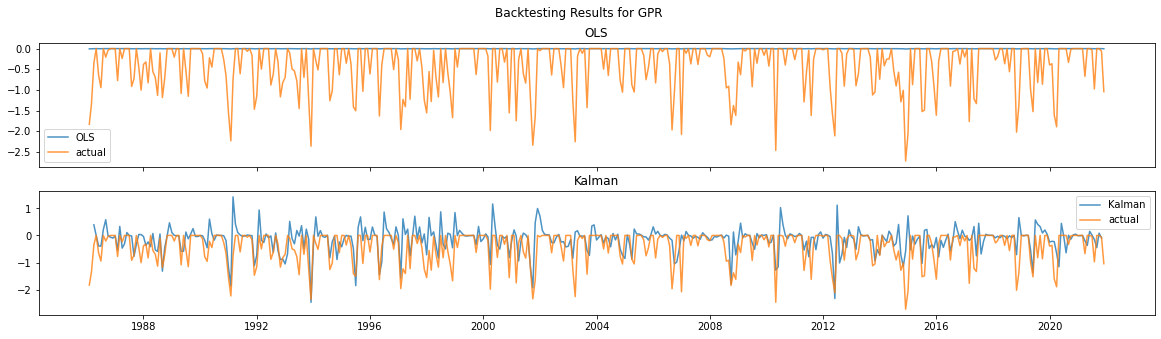

In [4]:
gpr_ols = DL('contract_1', 'GPRI', wti.join(gpr_shocks).dropna(), lags=1)
backtest(wti.contract_1, 
         {'OLS': ols_backtest(wti.contract_1, gpr_ols.model, lags=1), 
          'Kalman': kalman_response_model.backtest()},
         start=min(wti.index), plot=True, figsize=(20, 5), x_label='GPR'
        )

## 2. Equity Market Risk

### S&P 500

The most interesting of markets studied is equity markets. Recent literature using panel regression suggests increased equity market risk (Isleimeyyeh, 2019), but the link between commodities and the equity market has been disputed (Daskalaki et al, 2014).

In [5]:
spx = clean_series('real', load('data/SP500.csv').pct_change())
kalman_beta_model = KF(lags=0)
spx_betas = kalman_beta_model.run('contract_1', 'real', wti.join(spx).dropna())

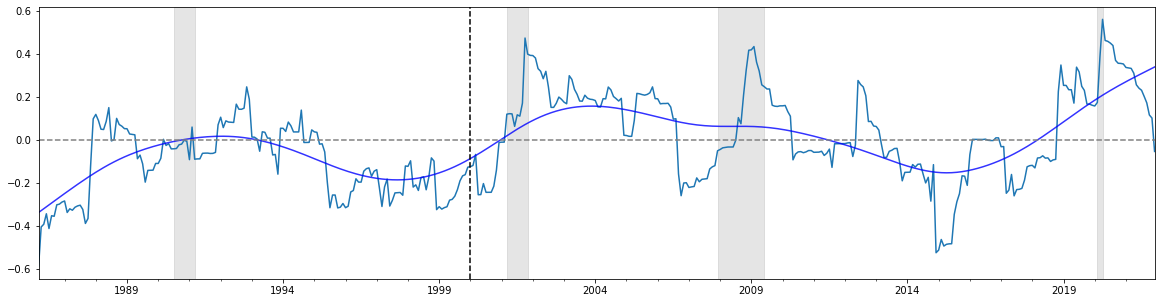

In [6]:
hp_kalman_plot(spx_betas, legend=False)

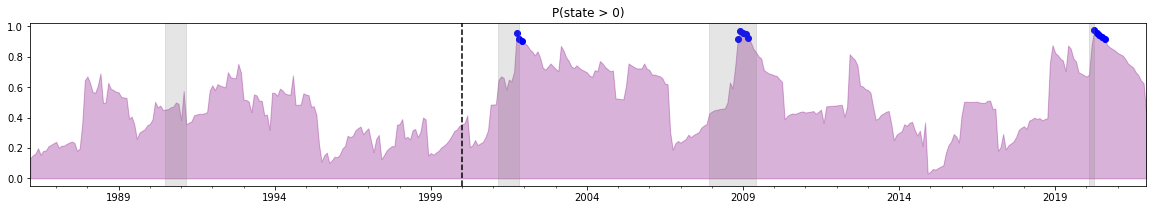

In [7]:
kalman_beta_model.plot_likelihood()

In [8]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.7089711054869609
RMSE Kalman: 0.6397083341653231


Recession periods are shaded in grey and a trendline was constructed using the Hodrick-Prescott filter. There appears to be an increase in equity risk post-financialization (dashed line indicating Jan 2000, around when financialization of commodity markets begun).

### VXO

To backup our findings, let's look at impulse response to perceived short-term (30-day) equity market uncertainty. While the VIX is commonly used, it doesn't go back far enough for us to see the pre-financilization trend. Instead, the VXO will be used, which takes volatility from the S&P 100 index as opposed to the VIX's S&P 500. Nevertheless, the indices are similar enough.

If there is increased equity risk feeding into WTI from financialization, we'd expect to see stronger negative returns following VXO shocks.

In [9]:
vxo_shocks = calc_shock('VXO', load('data/VXO.csv'))
vxo_response = kalman_response_model.run('contract_1', 'VXO', wti.join(vxo_shocks.dropna()))

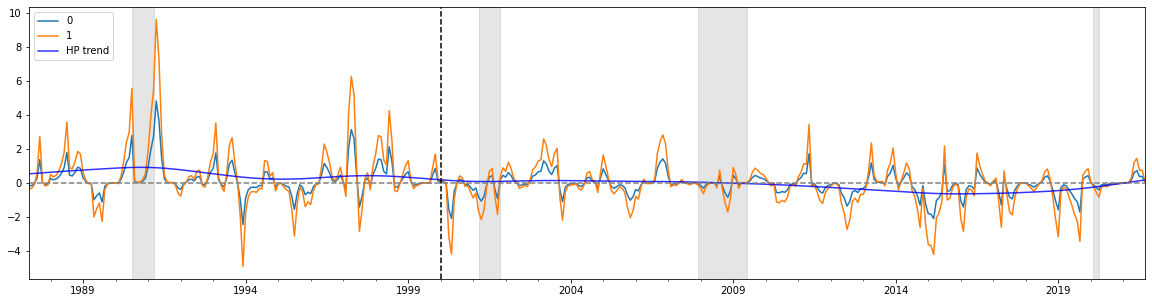

In [10]:
hp_kalman_plot(vxo_response)

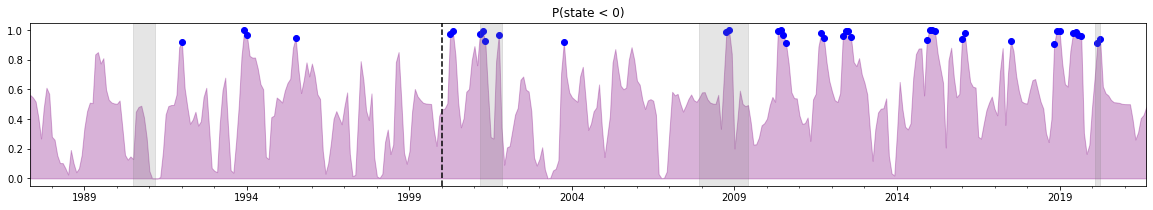

In [11]:
kalman_response_model.plot_likelihood(direction='<')

In [12]:
backtest(wti.contract_1, {'Kalman': kalman_response_model.backtest()})

RMSE Random Walk: 0.7089711054869609
RMSE Kalman: 0.5975740470708619


Even without the HP trendline, we see that there is a consistent pattern of lower response following VXO shocks after the 2008 recession. However, is it financialization or simply a response to the recession? We can argue that the former is not mutually exclusive with the latter. To back up our theory, let's see if the trend holds for global equity markets in general.

### MSCI World

The MSCI World index is comprised of equity indices from developed markets.

In [13]:
msci_world = clean_series('real', load('data/MSCI_World.csv').pct_change())
msci_world_betas = kalman_beta_model.run('contract_1', 'real', wti.join(msci_world).dropna())

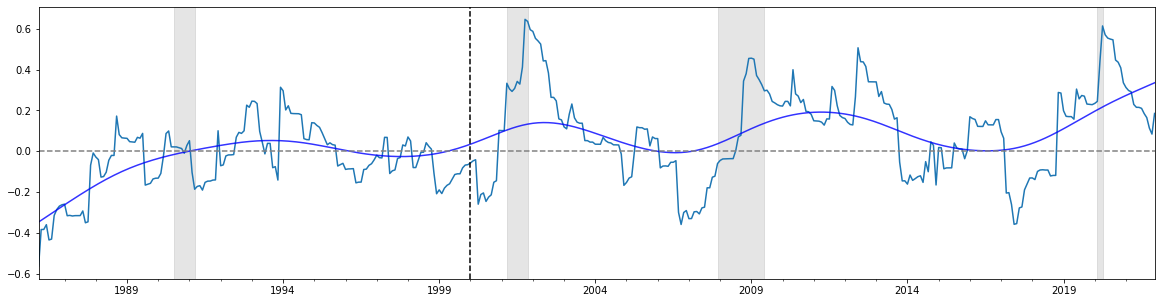

In [14]:
hp_kalman_plot(msci_world_betas, legend=False)

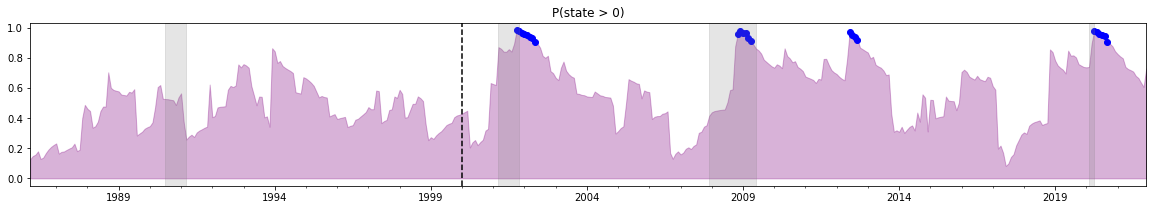

In [15]:
kalman_beta_model.plot_likelihood()

In [16]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.7089711054869609
RMSE Kalman: 0.6333128900633024


### MSCI Emerging Markets

As its name suggests, MSCI Emerging Markets (EM) is an index for emerging market equities.

In [17]:
msci_em = clean_series('real', load('data/MSCI_EM.csv').pct_change())
msci_em_betas = kalman_beta_model.run('contract_1', 'real', wti.join(msci_em).dropna())

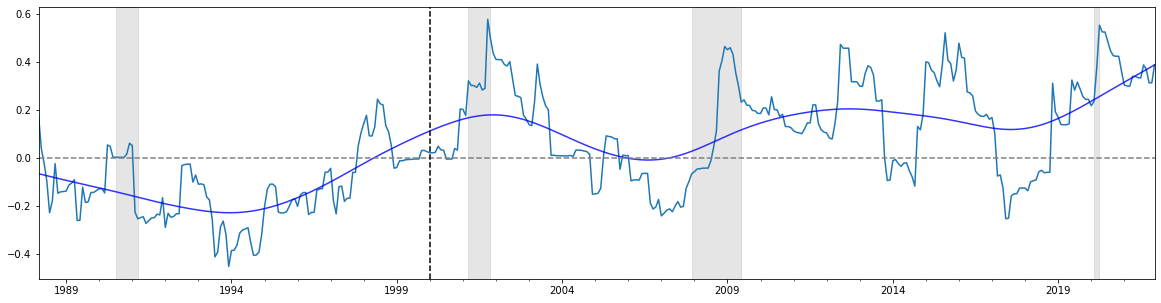

In [18]:
hp_kalman_plot(msci_em_betas, legend=False)

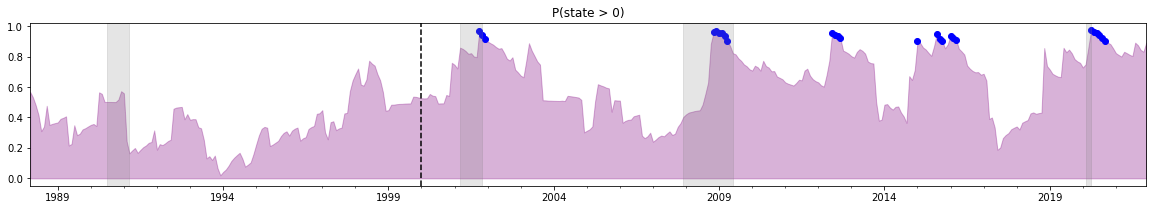

In [19]:
kalman_beta_model.plot_likelihood()

In [20]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.7089711054869609
RMSE Kalman: 0.638319070109547


A clear trend emerges from the MSCI indices for both the developed and developing equity markets - one that is robust to market cycles. Judging from the RMSE, the MSCI Emerging Markets index has a greater explainability for oil returns than the S&P 500 or MSCI World. The importance of developing market demand has been explored in Killian and Hicks (2013).

### Economic Policy Uncertainty

Why the increased equity market risk? One explanation is that there is an increased focus on economic indicators as financialization brings in more investors/speculators from the general market who incorporate economic information into their pricing.

We use the news-based economic policy uncertainty index by Baker et al (2016) as a proxy for response to economic shocks in the market. If the equity risk is driven by increasing attention to economic factors, then this would be a good way to confirm out suspicions.

In [21]:
epu_shocks = calc_shock('GEPU_current', load('data/EPUGlobal.csv'))
epu_responses = kalman_response_model.run('contract_1', 'GEPU_current', wti.join(epu_shocks).dropna())

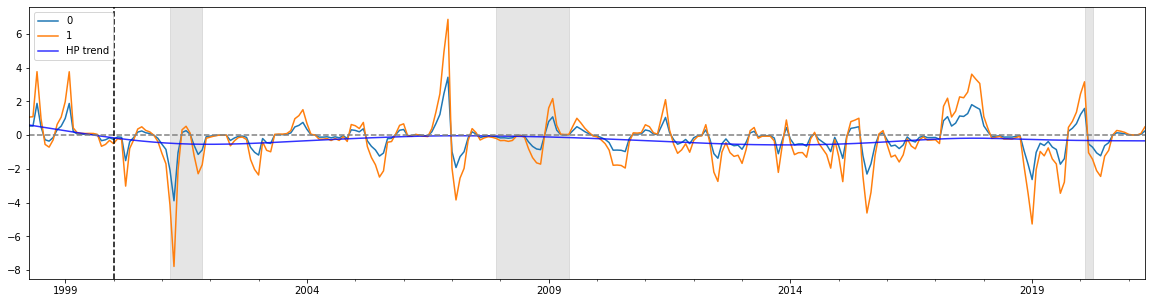

In [22]:
hp_kalman_plot(epu_responses)

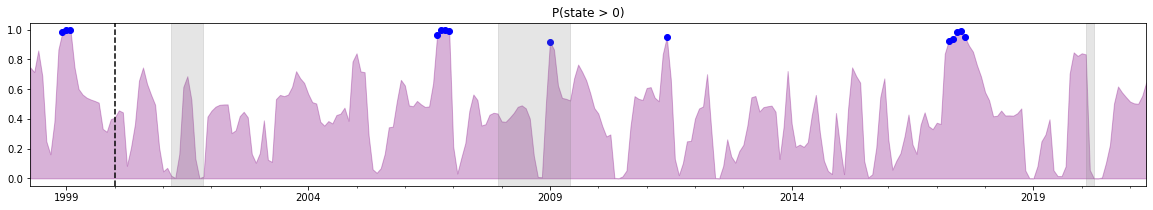

In [23]:
kalman_response_model.plot_likelihood()

In [24]:
backtest(wti.contract_1, {'Kalman': kalman_response_model.backtest()})

RMSE Random Walk: 0.7089711054869609
RMSE Kalman: 0.587906048121445


Since the global EPU index doesn't go back that far, we'll also have a look at the US EPU index. Since US was the dominant economic power for the late 20th century, it should be a good approximation for global EPU pre-2000.

In [25]:
us_epu_shocks = calc_shock('aggregate', load('data/EPU_US.csv'))
us_epu_responses = kalman_response_model.run('contract_1', 'aggregate', wti.join(us_epu_shocks).dropna())

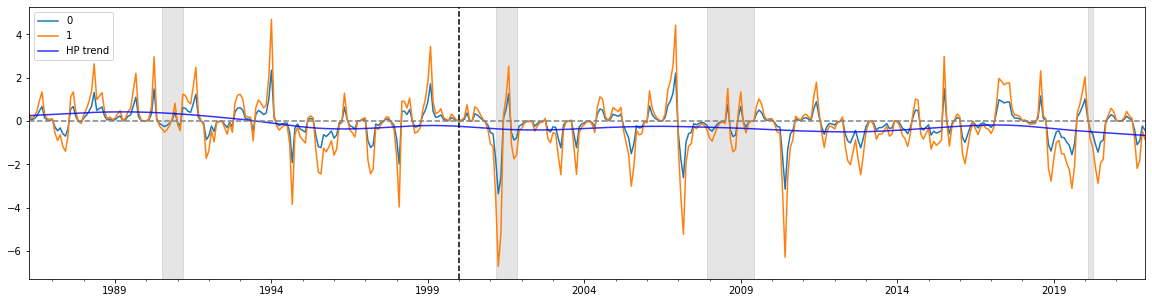

In [26]:
hp_kalman_plot(us_epu_responses)

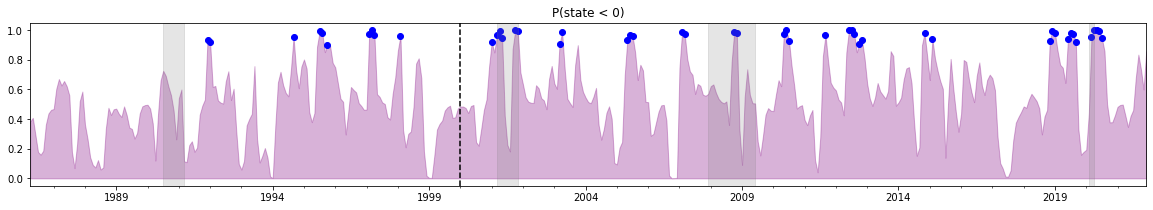

In [27]:
kalman_response_model.plot_likelihood(direction='<')

In [28]:
backtest(wti.contract_1, {'Kalman': kalman_response_model.backtest()})

RMSE Random Walk: 0.7089711054869609
RMSE Kalman: 0.5985781680574966


Overall we see similar trends for both the global EPU and the US EPU - spikes in EPU are more likely to invoke a negative response from the market after 2000.

## 3. Commodity Market Risk

### GSCI Non-Energy

In [29]:
gsneci = clean_series('real', load('data/GSNECI.csv').pct_change())
gsneci_betas = kalman_beta_model.run('contract_1', 'real', wti.join(gsneci).dropna())

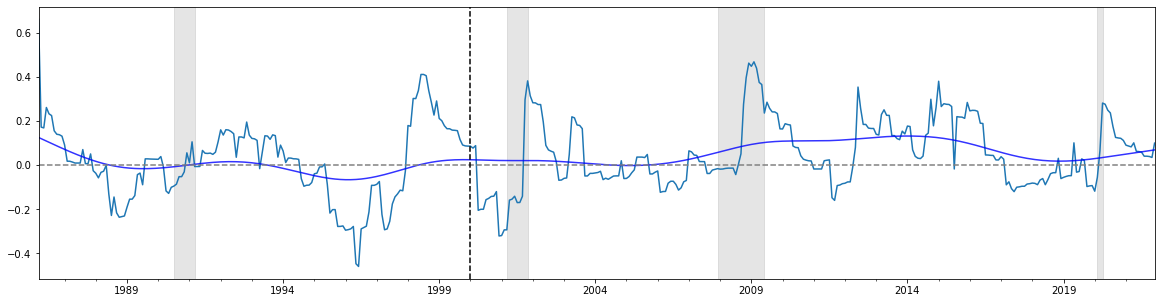

In [30]:
hp_kalman_plot(gsneci_betas, legend=False)

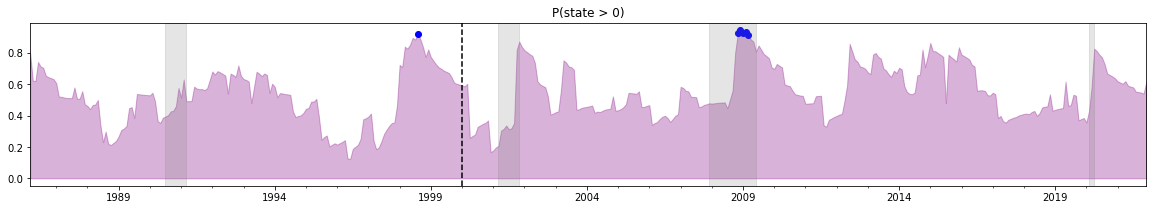

In [31]:
kalman_beta_model.plot_likelihood()

In [32]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.7089711054869609
RMSE Kalman: 0.6594445427434847


It appears that not only is WTI being more closely correlated with equities and economic factors, but also commodities in general. These trends suggest that financialization increased the link between WTI to other markets such as equities and non-energy commodities, perhaps because financialization is by definition the inclusion of investors who previously did not have access to the market. It then makes sense that these investors would incorporate different information sets into their pricing.

### US Field Production

In [33]:
prod = clean_series('production', load('data/US_production.csv').pct_change())
prod_betas = kalman_beta_model.run('contract_1', 'production', wti.join(prod).dropna())

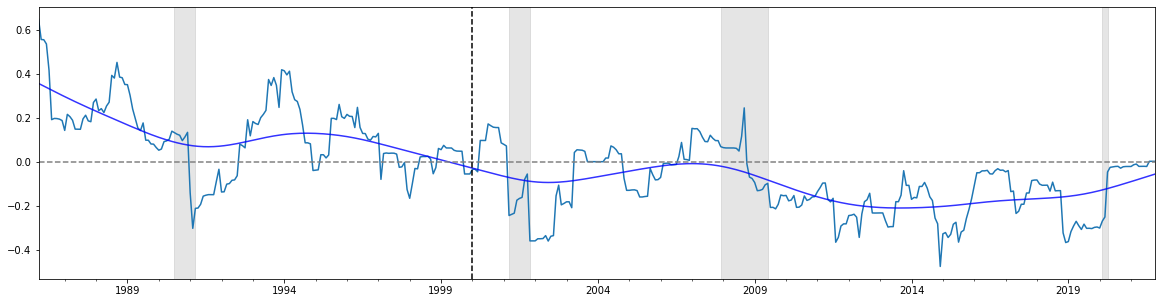

In [34]:
hp_kalman_plot(prod_betas, legend=False)

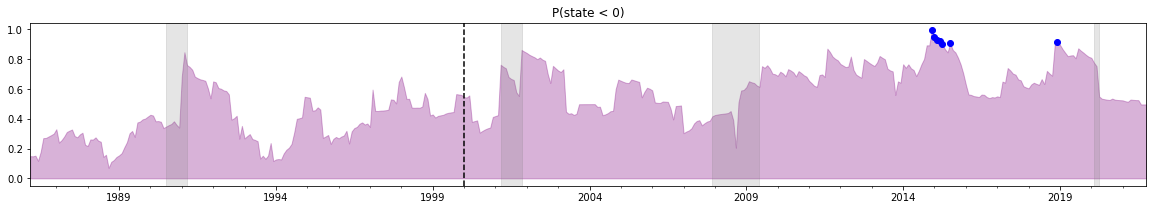

In [35]:
kalman_beta_model.plot_likelihood(direction='<')

In [36]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.7089711054869609
RMSE Kalman: 0.6519928807785552


### World Petroleum Production

In [37]:
prod = clean_series('production', load('data/Global_production.csv').pct_change())
prod_betas = kalman_beta_model.run('contract_1', 'production', wti.join(prod).dropna())

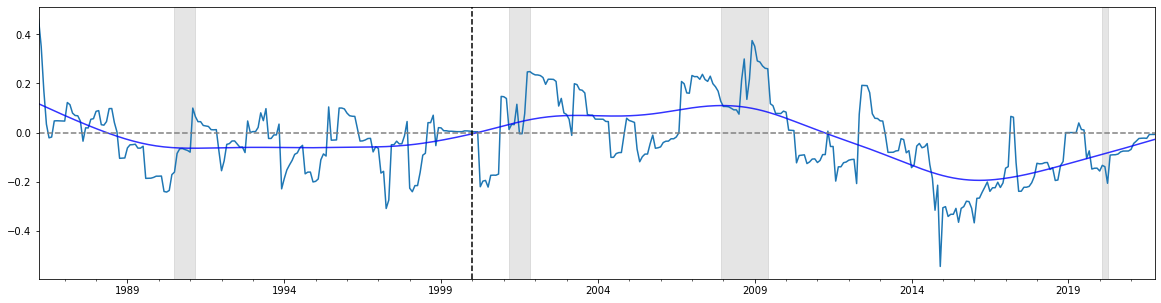

In [38]:
hp_kalman_plot(prod_betas, legend=False)

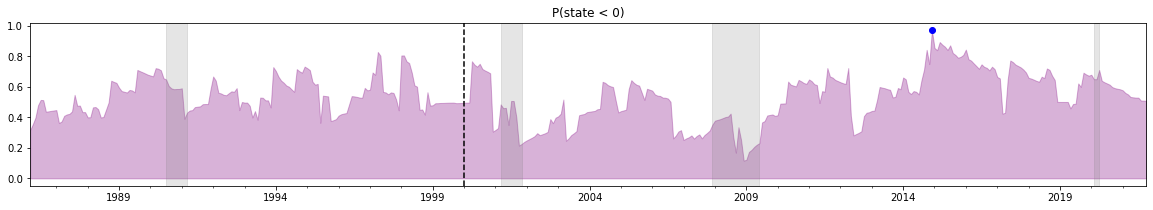

In [39]:
kalman_beta_model.plot_likelihood(direction='<')

In [40]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.7089711054869609
RMSE Kalman: 0.666121457314176


# Upward Movements

## GPRI

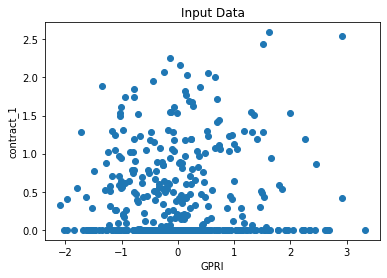

In [41]:
wti = clean_series('contract_1', load('data/WTI.csv').pct_change())
wti.contract_1 = wti.contract_1.apply(lambda x: 0 if x < 0 else x)
gpr_shocks = calc_shock('GPRI', load('data/GPRGlobal.csv'))
kalman_response_model = KF(lags=1)
gpr_response = kalman_response_model.run('contract_1', 'GPRI', wti.join(gpr_shocks).dropna(), show_scatter=True)

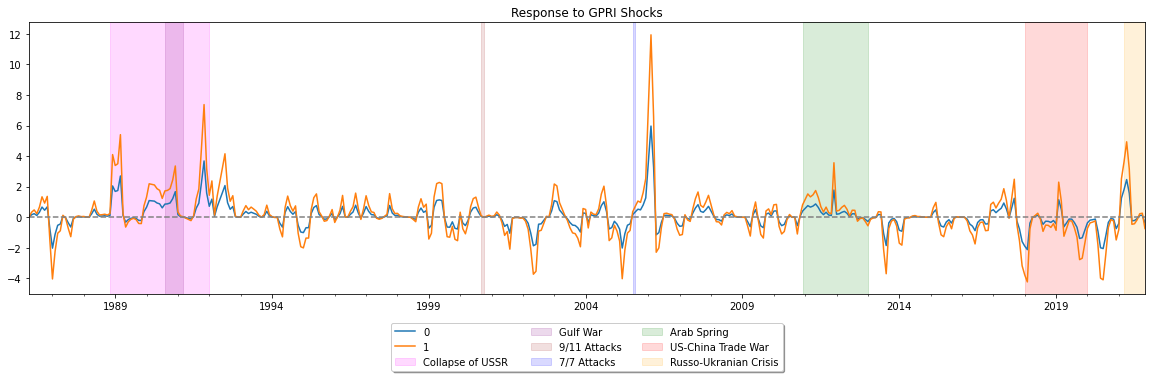

In [42]:
hp_kalman_plot(gpr_response, hp_trend=False, recessions=False, geopolitics=True, splitline=False,
              title='Response to GPRI Shocks')

RMSE Random Walk: 0.6976963256077154
RMSE OLS: 0.6347856646066692
RMSE Kalman: 0.6122536666412751


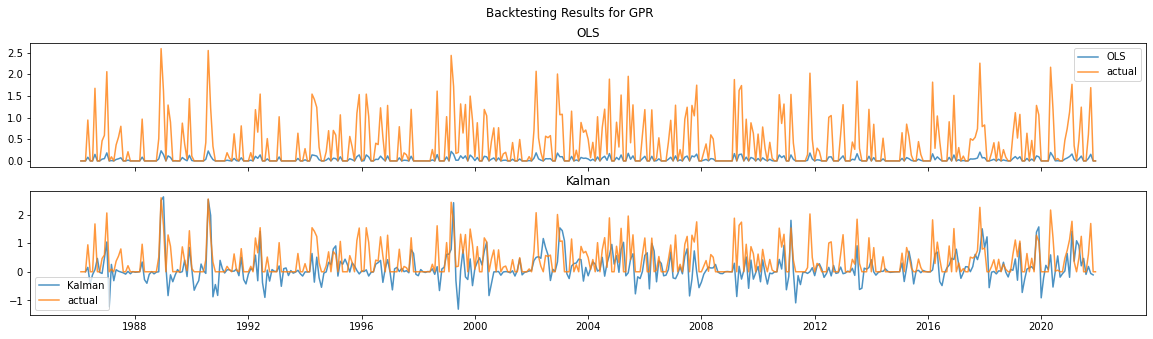

In [43]:
gpr_ols = DL('contract_1', 'GPRI', wti.join(gpr_shocks).dropna(), lags=1)
backtest(wti.contract_1, 
         {'OLS': ols_backtest(wti.contract_1, gpr_ols.model, lags=1), 
          'Kalman': kalman_response_model.backtest()},
         start=min(wti.index), plot=True, figsize=(20, 5), x_label='GPR'
        )

## S&P 500

In [44]:
spx = clean_series('real', load('data/SP500.csv').pct_change())
kalman_beta_model = KF(lags=0)
spx_betas2 = kalman_beta_model.run('contract_1', 'real', wti.join(spx).dropna())

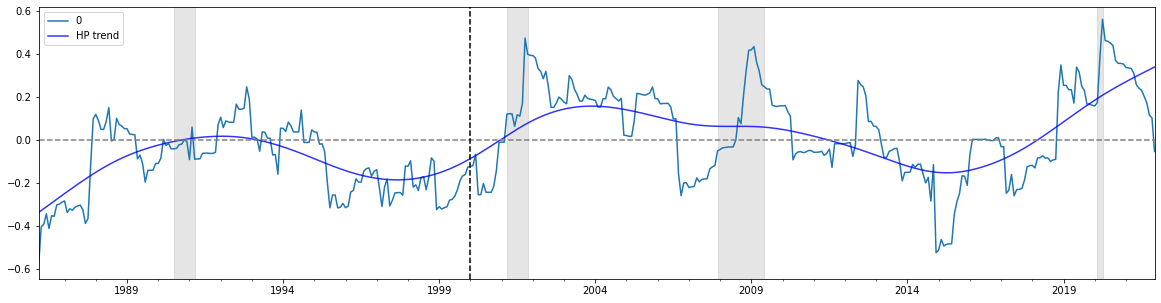

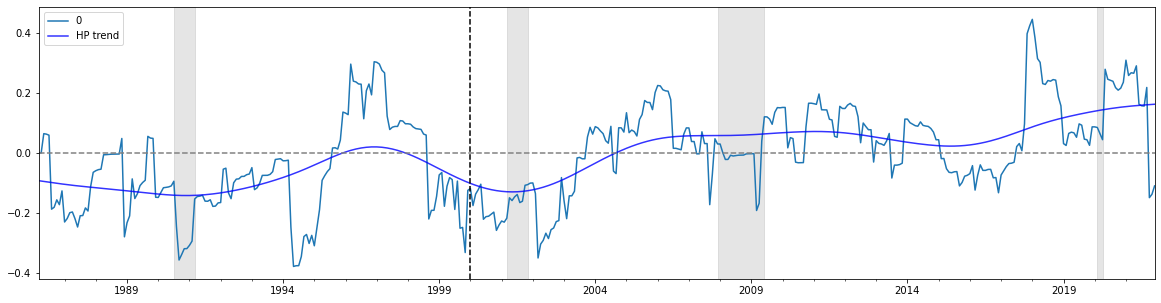

In [45]:
hp_kalman_plot(spx_betas)
hp_kalman_plot(spx_betas2)

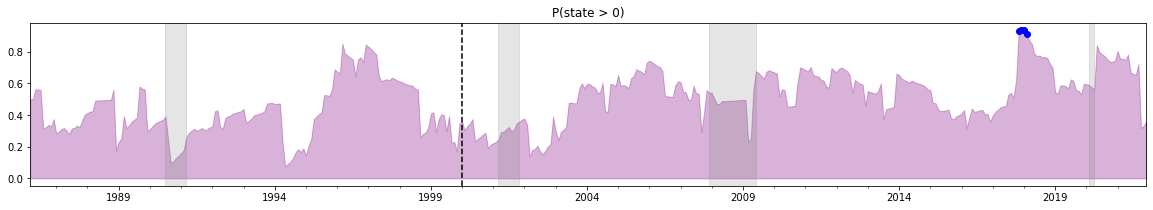

In [46]:
kalman_beta_model.plot_likelihood()

In [47]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.6976963256077154
RMSE Kalman: 0.6518735793355852


## MSCI World

In [48]:
msci_world = clean_series('real', load('data/MSCI_World.csv').pct_change())
msci_world_betas2 = kalman_beta_model.run('contract_1', 'real', wti.join(msci_world).dropna())

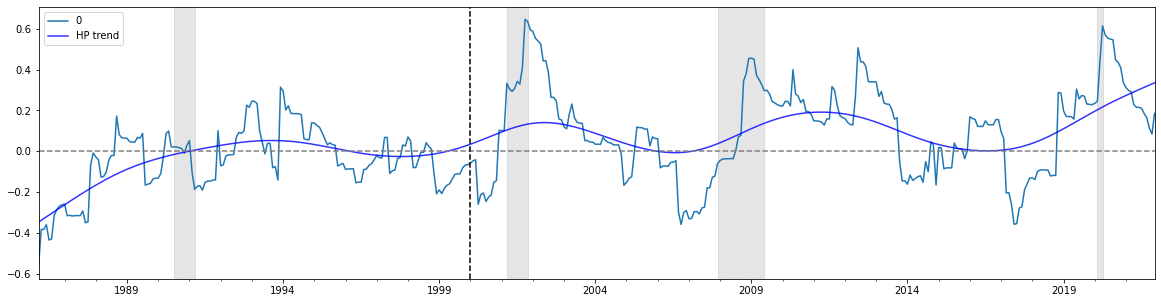

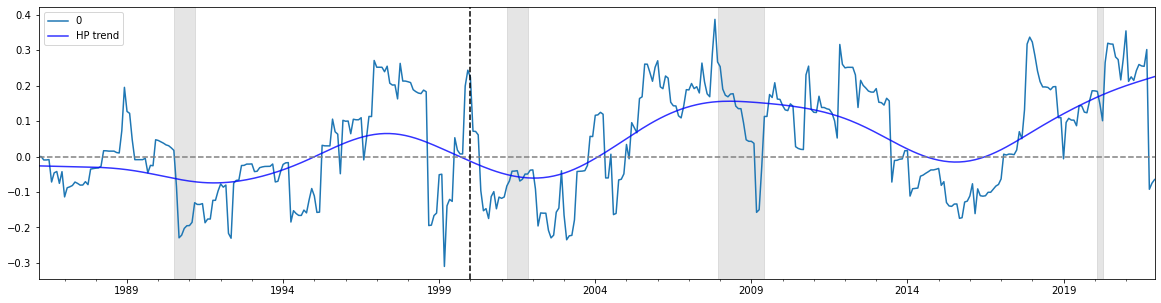

In [49]:
hp_kalman_plot(msci_world_betas)
hp_kalman_plot(msci_world_betas2)

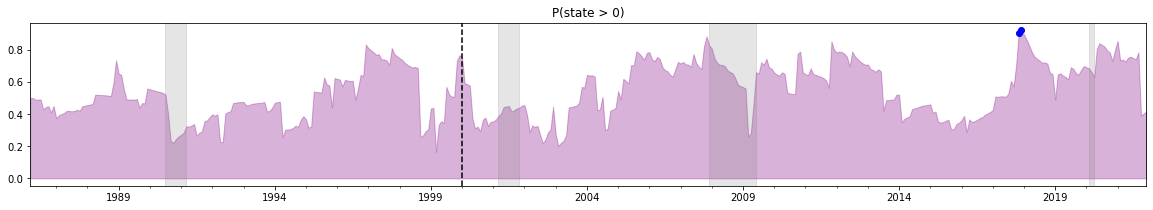

In [50]:
kalman_beta_model.plot_likelihood()

In [51]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.6976963256077154
RMSE Kalman: 0.6554889153214147


## MSCI Emerging Markets

In [52]:
msci_em = clean_series('real', load('data/MSCI_EM.csv').pct_change())
msci_em_betas2 = kalman_beta_model.run('contract_1', 'real', wti.join(msci_em).dropna())

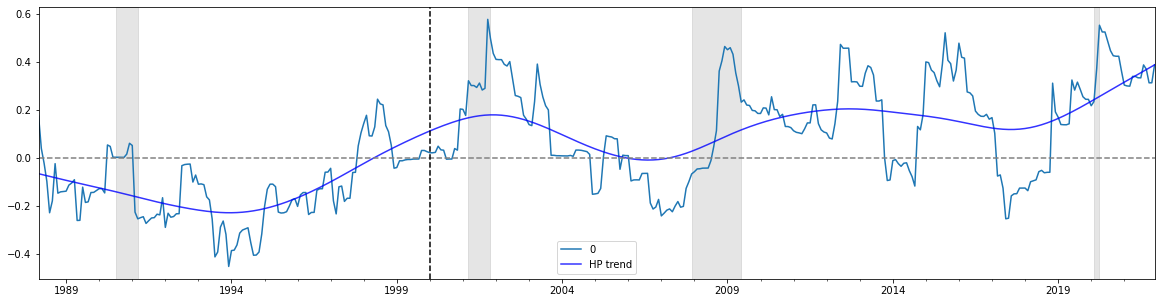

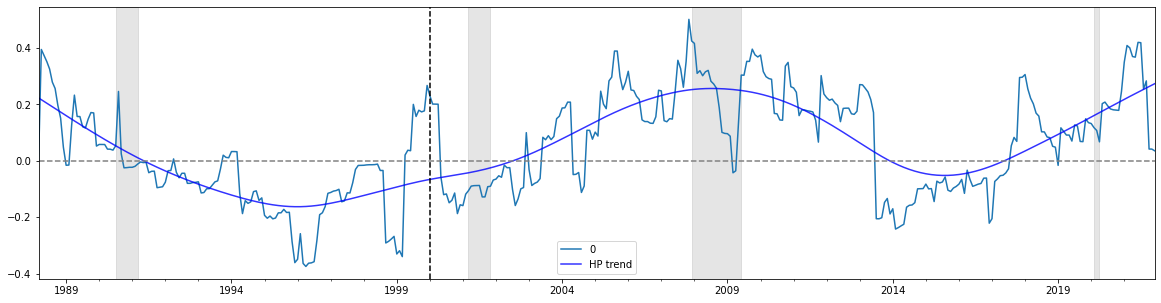

In [53]:
hp_kalman_plot(msci_em_betas)
hp_kalman_plot(msci_em_betas2)

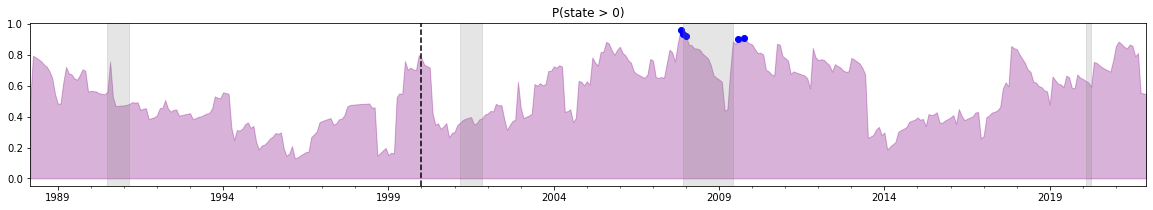

In [54]:
kalman_beta_model.plot_likelihood()

In [55]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.6976963256077154
RMSE Kalman: 0.6490736810901401
